In [127]:
import math
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [178]:
class SnakeExtended:
    """
    Should add in plotting and boundary condition specification methods.
    """

    def __init__(self, B=1, c=10, l=1, sigma=0.1, rho=1, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.bt = self.B / self.c
        self.sigma = sigma
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        # self.l = self.lg*np.power(c/B, 1/3)
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((4, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        self.y[0, 0] = np.pi / 2
        self.y[0, -1] = 0
        dy_ds = np.exp(-((self.x - 0.75) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, -self.x, initial=0) / si.trapz(dy_ds, self.x)
            + np.pi / 2
        )  # want s=0 to be at pi/2 so need to do integral backwards
        d2y_ds2 = np.gradient(dy_ds, self.x, edge_order=2)
        d3y_ds3 = np.gradient(d2y_ds2, self.x, edge_order=2)
        self.y[0, :] = y_guess
        self.y[1, :] = dy_ds
        self.y[2, :] = d2y_ds2
        self.y[3, :] = d3y_ds3

    def fun_k(self, x, y):

        dy0_dx = y[1]
        dy1_dx = y[2]
        dy2_dx = y[3]
        dy3_dx = -(1 + self.bt) / (self.sigma**2) * y[2] + (
            self.rho * self.g * self.l**3
        ) / (self.c * self.sigma**2) * x * np.cos(y[0])
        dy_dx = np.vstack((dy0_dx, dy1_dx, dy2_dx, dy3_dx))
        return dy_dx

    def bc(self, ya, yb):
        res1 = ya[0] - np.pi / 2
        res2 = yb[0]
        res3 = ya[1]
        # res4 = ya[2]
        res5 = ya[3]
        residuals = np.array([res1, res2, res3, res5])
        return residuals

    def solve(self, verbose=0):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, verbose=verbose
        )
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.x_pos -= self.x_pos[-1]
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos -= self.y_pos[-1]

    def cost(self, alpha=0.5):
        height_term = self.y_pos[0] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

In [262]:
snake = SnakeExtended(B=1, c=0.09, l=0.1)

In [263]:
snake.solve(verbose=1)

Solved in 5 iterations, number of nodes 168. 
Maximum relative residual: 9.56e-04 
Maximum boundary residual: 6.38e-22


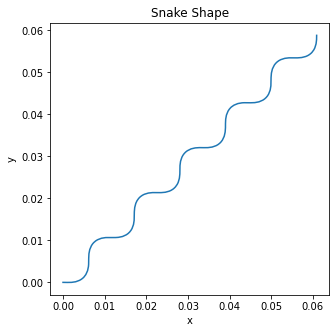

In [264]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.plot(-snake.x_pos, -snake.y_pos)
ax.set_title("Snake Shape")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim()
plt.show()

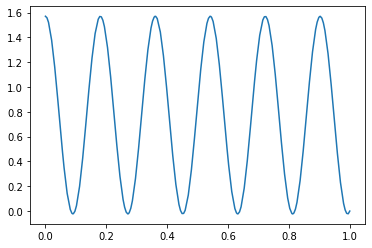

In [265]:
plt.plot(snake.sol.x, snake.sol.y[0])
plt.show()

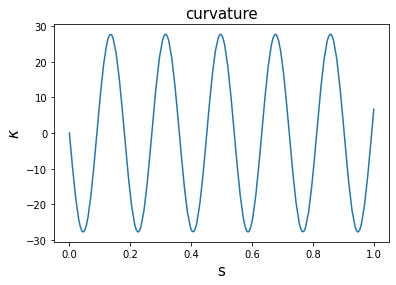

In [266]:
plt.plot(snake.sol.x, snake.sol.y[1])
plt.title("curvature", fontsize=15)
plt.ylabel(r"$\kappa$", fontsize=15)
plt.xlabel("s", fontsize=15)
plt.show()

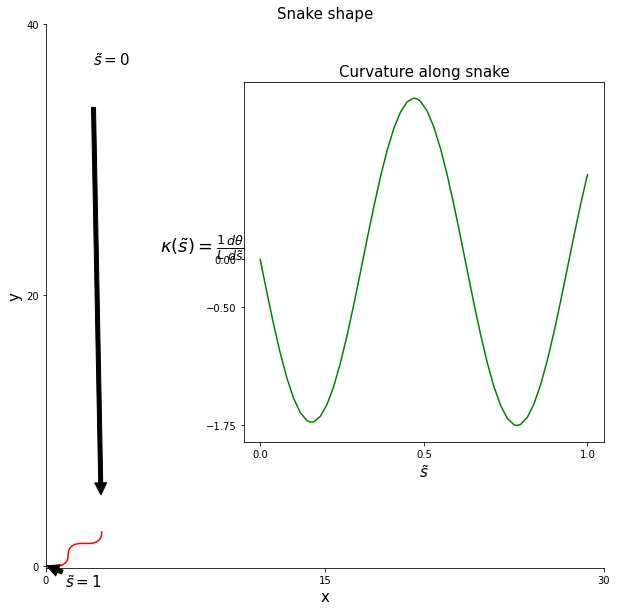

In [112]:
fig, ax1 = plt.subplots(figsize=(10, 10))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.4, 0.3, 0.5, 0.5]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(-snake.x_pos, -snake.y_pos, color="red")
ax1.set_xlim([0, 30])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
# ax1.spines["bottom"].set_visible(False)
ax1.set_xlabel("x", fontsize=15)
ax1.set_xticks([0, 15, 30])
ax1.set_ylabel("y", fontsize=15)
ax1.set_yticks([0, 20, 40])
ax1.set_title("Snake shape", fontsize=15)

ax1.annotate(
    r"$\tilde{s}=0$",
    xy=(-snake.x_pos[0], -snake.y_pos[0]),
    xycoords="data",
    xytext=(0.15, 0.95),
    fontsize=15,
    textcoords="axes fraction",
    arrowprops=dict(facecolor="black", shrink=0.08),
    horizontalalignment="right",
    verticalalignment="top",
)
ax1.annotate(
    r"$\tilde{s}=1$",
    xy=(-snake.x_pos[-1], -snake.y_pos[-1]),
    xycoords="data",
    xytext=(0.1, -0.01),
    fontsize=15,
    textcoords="axes fraction",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="right",
    verticalalignment="top",
)

ax2.plot(snake.sol.x, snake.sol.y[1] / snake.l, color="green")
ax2.set_xlabel(r"$\tilde{s}$", fontsize=15)
ax2.set_xticks([0, 0.5, 1])
ax2.set_ylabel(
    r"$\kappa(\tilde{s}) = \frac{1}{L}\frac{d\theta}{d\tilde{s}}$",
    fontsize=18,
    rotation=0,
)
ax2.set_yticks([-1.75, -0.5, 0])
ax2.set_title("Curvature along snake", fontsize=15)

plt.show()